<a href="https://colab.research.google.com/github/Toan02Ky-UIT/ComputerVisionProject/blob/main/final_resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub

path = kagglehub.dataset_download("mohamedmaher5/vehicle-classification")
path

100%|██████████| 827M/827M [00:38<00:00, 22.6MB/s]

Extracting files...


'/root/.cache/kagglehub/datasets/mohamedmaher5/vehicle-classification/versions/1'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!mkdir -p "/content/drive/MyDrive/vehicle2"

In [ ]:
!cp -r "{path}" "/content/drive/MyDrive/vehicle2"

In [ ]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import copy
import time
import os


In [ ]:
data_dir = "/content/drive/MyDrive/vehicle2/1/Vehicles"
batch_size = 32
img_size = 224

def fix_image(img):
    if img.mode == "P":
        img = img.convert("RGBA")
    if img.mode == "RGBA":
        img = img.convert("RGB")
    return img

train_tf = transforms.Compose([
    transforms.Lambda(fix_image),
    transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])


test_tf = transforms.Compose([
    transforms.Lambda(fix_image),
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225]),
])

full_dataset = datasets.ImageFolder(data_dir)

n = len(full_dataset)
train_len = int(n * 0.8)
val_len = int(n * 0.1)
test_len = n - train_len - val_len

train_subset, val_subset, test_subset = random_split(full_dataset, [train_len, val_len, test_len])

train_subset.dataset = datasets.ImageFolder(data_dir, transform=train_tf)
val_subset.dataset  = datasets.ImageFolder(data_dir, transform=test_tf)
test_subset.dataset = datasets.ImageFolder(data_dir, transform=test_tf)

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

num_classes = len(full_dataset.classes)

In [ ]:
def get_model(num_classes):
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

    in_f = model.fc.in_features

    model.fc = nn.Linear(in_f, num_classes)

    for param in model.parameters():
        param.requires_grad = False

    for param in model.fc.parameters():
        param.requires_grad = True

    return model

In [ ]:
def train_model(model, name):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=3)
    criterion = nn.CrossEntropyLoss()

    best_weights = copy.deepcopy(model.state_dict())
    best_acc = 0
    best_loss = float("inf")
    es_loss = float("inf")
    patience, stop_counter = 7, 0

    for epoch in range(200):
        model.train()
        train_loss, correct, total = 0, 0, 0

        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            out = model(imgs)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * imgs.size(0)
            _, preds = torch.max(out, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        train_loss /= total

        model.eval()
        correct, total, val_loss = 0, 0, 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                out = model(imgs)
                val_loss += criterion(out, labels).item() * imgs.size(0)
                _, preds = torch.max(out, 1)
                total += labels.size(0)
                correct += (preds == labels).sum().item()

        val_acc = correct / total
        val_loss /= total
        scheduler.step(val_loss)

        print(f"{name} → Epoch {epoch+1} | train acc={train_acc:.4f} | train loss={train_loss:.4f} | "
          f"val acc={val_acc:.4f} | val loss={val_loss:.4f} | lr={optimizer.param_groups[0]['lr']:.6f}")


        if (val_acc > best_acc) or (val_acc == best_acc and val_loss < best_loss):
            best_acc = val_acc
            best_loss = val_loss
            best_weights = copy.deepcopy(model.state_dict())
            torch.save(best_weights, f"/content/drive/MyDrive/vehicle2/{name}_best.pt")
            print("  ✓ Saved best checkpoint")

        if val_loss < es_loss:
            es_loss = val_loss
            stop_counter = 0
        else:
            stop_counter += 1
            if stop_counter >= patience:
                print(" Early stopping")
                break

    model.load_state_dict(best_weights)
    return model


In [ ]:
def evaluate(model, name):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    y_true, y_pred = [], []
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs = imgs.to(device)
            out = model(imgs)
            _, preds = torch.max(out, 1)
            y_true.extend(labels.numpy())
            y_pred.extend(preds.cpu().numpy())

    print(f"\n=== {name} — Metrics ===")
    print(classification_report(y_true, y_pred, target_names=full_dataset.classes, digits=4))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

In [ ]:
model_list = ["resnet50"]

for m in model_list:
    print(f"\n================ RUN MODEL: {m} ================")
    model = get_model(num_classes)
    trained = train_model(model, m)
    evaluate(trained, m)



================ RUN MODEL: resnet50 ================
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 116MB/s]
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


resnet50 → Epoch 1 | train acc=0.9074 | train loss=0.5618 | val acc=0.9749 | val loss=0.1814 | lr=0.001000
  ✓ Saved best checkpoint
resnet50 → Epoch 2 | train acc=0.9723 | train loss=0.1590 | val acc=0.9821 | val loss=0.0955 | lr=0.001000
  ✓ Saved best checkpoint
resnet50 → Epoch 3 | train acc=0.9812 | train loss=0.1055 | val acc=0.9928 | val loss=0.0653 | lr=0.001000
  ✓ Saved best checkpoint
resnet50 → Epoch 4 | train acc=0.9808 | train loss=0.0886 | val acc=0.9857 | val loss=0.0568 | lr=0.001000
resnet50 → Epoch 5 | train acc=0.9859 | train loss=0.0734 | val acc=0.9857 | val loss=0.0496 | lr=0.001000
resnet50 → Epoch 6 | train acc=0.9848 | train loss=0.0667 | val acc=0.9946 | val loss=0.0350 | lr=0.001000
  ✓ Saved best checkpoint
resnet50 → Epoch 7 | train acc=0.9890 | train loss=0.0572 | val acc=0.9964 | val loss=0.0327 | lr=0.001000
  ✓ Saved best checkpoint
resnet50 → Epoch 8 | train acc=0.9899 | train loss=0.0485 | val acc=0.9946 | val loss=0.0289 | lr=0.001000
resnet50 → Epo

Found 4 misclassified images.


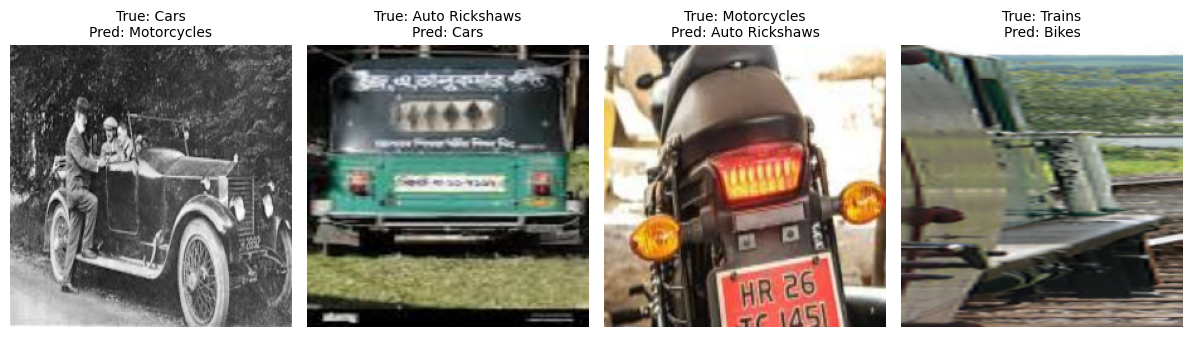

In [ ]:
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trained.to(device)
trained.eval()

misclassified_images = []
true_labels = []
predicted_labels = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = trained(imgs)
        _, preds = torch.max(outputs, 1)

        for i in range(len(labels)):
            if preds[i] != labels[i]:
                misclassified_images.append(imgs[i].cpu())
                true_labels.append(labels[i].cpu())
                predicted_labels.append(preds[i].cpu())

mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

num_misclassified = len(misclassified_images)
print(f"Found {num_misclassified} misclassified images.")

if num_misclassified > 0:
    display_count = min(num_misclassified, 15)

    fig = plt.figure(figsize=(15, 5 * ((display_count + 4) // 5)))
    for i in range(display_count):
        img = misclassified_images[i]

        img = img * std + mean

        img = torch.clamp(img, 0, 1)

        img = img.numpy().transpose((1, 2, 0))

        ax = fig.add_subplot((display_count + 4) // 5, 5, i + 1)
        ax.imshow(img)
        true_class = full_dataset.classes[true_labels[i].item()]
        pred_class = full_dataset.classes[predicted_labels[i].item()]
        ax.set_title(f"True: {true_class}\nPred: {pred_class}", fontsize=10)
        ax.axis("off")

    plt.tight_layout()
    plt.show()
else:
    print("No misclassified images found in the test set.")

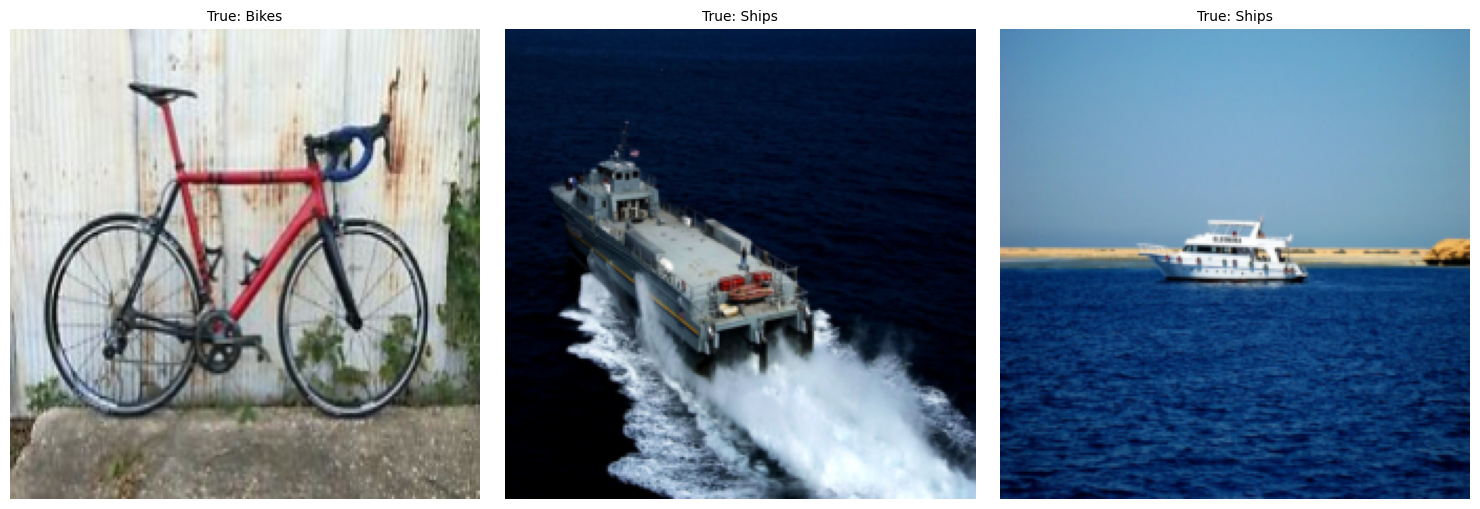

In [ ]:
import matplotlib.pyplot as plt
import random

all_test_images = []
all_test_labels = []

for imgs, labels in test_loader:
    for i in range(len(labels)):
        all_test_images.append(imgs[i].cpu())
        all_test_labels.append(labels[i].cpu())
    if len(all_test_images) >= 100:
        break

num_images_to_display = 3
if len(all_test_images) < num_images_to_display:
    num_images_to_display = len(all_test_images)

random_indices = random.sample(range(len(all_test_images)), num_images_to_display)

selected_images = [all_test_images[i] for i in random_indices]
selected_labels = [all_test_labels[i] for i in random_indices]

mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

if num_images_to_display > 0:
    fig = plt.figure(figsize=(15, 5))
    for i in range(num_images_to_display):
        img = selected_images[i]

        img = img * std + mean
        img = torch.clamp(img, 0, 1)

        img = img.numpy().transpose((1, 2, 0))

        ax = fig.add_subplot(1, num_images_to_display, i + 1)
        ax.imshow(img)
        true_class = full_dataset.classes[selected_labels[i].item()]
        ax.set_title(f"True: {true_class}", fontsize=10)
        ax.axis("off")

    plt.tight_layout()
    plt.show()
else:
    print("No images found to display.")
